# Deep Neural Network on 2D Data

Note the *2D* part refers to the ball is being shot from a point to different points in the goal, **not** that the input features are 2D. In fact, the input features are 4D `[x, y, dx, dy]` vectors

### Load Data

In [104]:
%store -r many_many_short

sideways = many_many_short.T

X, Y = np.array(sideways[:4]).astype(float), np.array(sideways.ix[4, :]).astype(int)

### Train

In [105]:
from nn.deep.model import NeuralNetwork

N, M = X.shape
nn = NeuralNetwork(X, Y, Hs=[4, 4], C=2, learning_rate=.1, regularizer=0, gradient_checking=False, inspect=True)

def states(iters):
    for _ in range(iters):
        nn.learn()
        yield nn.info
        
states = list(states(50000))

### Plot Losses

In [106]:
from collections import namedtuple

Layers = namedtuple('Layers', ['dW1', 'dW2', 'dW3', 'db1', 'db2', 'db3'])

def gradient_magnitudes_generator():
    for state in states:
        gs = state.gradients

        dW_avgs = [np.abs(dW).mean() for dW in gs['dWs']]
        db_avgs = [np.abs(db).mean() for db in gs['dbs']]

        yield Layers(*dW_avgs, *db_avgs)
        
gradient_magnitudes = list(gradient_magnitudes_generator())

%matplotlib qt
pd.DataFrame(gradient_magnitudes, columns=Layers._fields).plot()

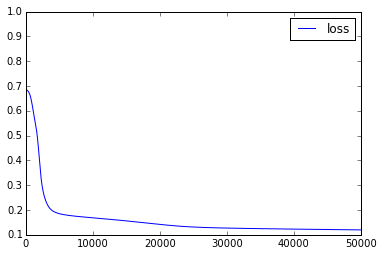

In [107]:
def loss_averages():
    for state in states:
        yield state.gradients['loss'].mean()
        
loss_avgs = list(loss_averages())

%matplotlib inline
pd.DataFrame(loss_avgs, columns=['loss']).plot()

### Visualize

Notice the plots are linear because of the following recurrence relation:

$$v_t = x_{t+1} - x_t$$

This formula follows by definition of $x_t$:

$$x_t = x_{t-1} + v_{t-1}$$

Intuitively, as the difference between $x$ points gets smaller, the difference between $y$ points get smaller **by the same amount**

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:26: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


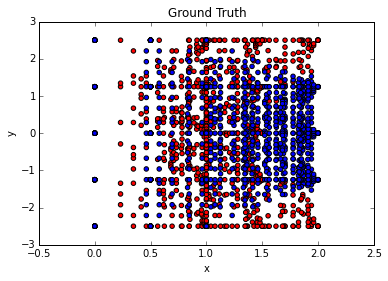

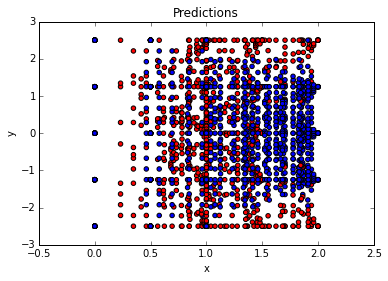

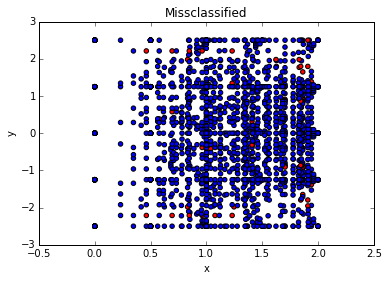

In [108]:
from ipywidgets import interact, fixed

@interact(X=fixed(X), Y=fixed(Y), many_many_short=fixed(many_many_short), view_index=(0, len(states)-1), states=fixed(states))
def plot(X, Y, many_many_short, view_index, states):
    """View decision boundary over time
    
    We have the state of the model (i.e. its parameters) after every time step.
    We want to see how the model learns over time. Hence create a one-off instance
    of a softmax with its old parameters and ask it to make a bunch of predictions!
    """
    s = states[view_index]
    nn = NeuralNetwork(X, ys_train=Y, Hs=[4, 4], C=2, params=s.params)
    
    # Plotting
    colormap = np.array(['r', 'b'])
    
    # Plot the gold standard in a plot right next to it
    many_many_short.plot(kind='scatter', x='x', y='y', c=colormap[many_many_short['label']], title='Ground Truth')

    # Predictions
    many_many_short['predictions'] = nn.predict(X)
    many_many_short.plot(kind='scatter', x='x', y='y', c=colormap[many_many_short['predictions']], title='Predictions')
    
    # Misclassified examples
    many_many_short['correct'] = many_many_short['label'] == many_many_short['predictions']
    many_many_short.plot(kind='scatter', x='x', y='y', c=colormap[many_many_short['correct']], title='Missclassified')

In [109]:
many_many_short['correct'].sum() / len(many_many_short)

0.9609375